In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plb
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pathlib import Path

from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn import metrics

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, Activation, Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, MaxPool2D
from tensorflow.keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, regularizers
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Model Architecture
from tensorflow.keras.applications import ResNet50V2

2024-06-30 14:12:36.696324: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-30 14:12:36.696443: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-30 14:12:36.792222: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# directories and paths
test_path = Path("/kaggle/input/brain-tumor-mri-dataset/Testing")
train_path = Path("/kaggle/input/brain-tumor-mri-dataset/Training")

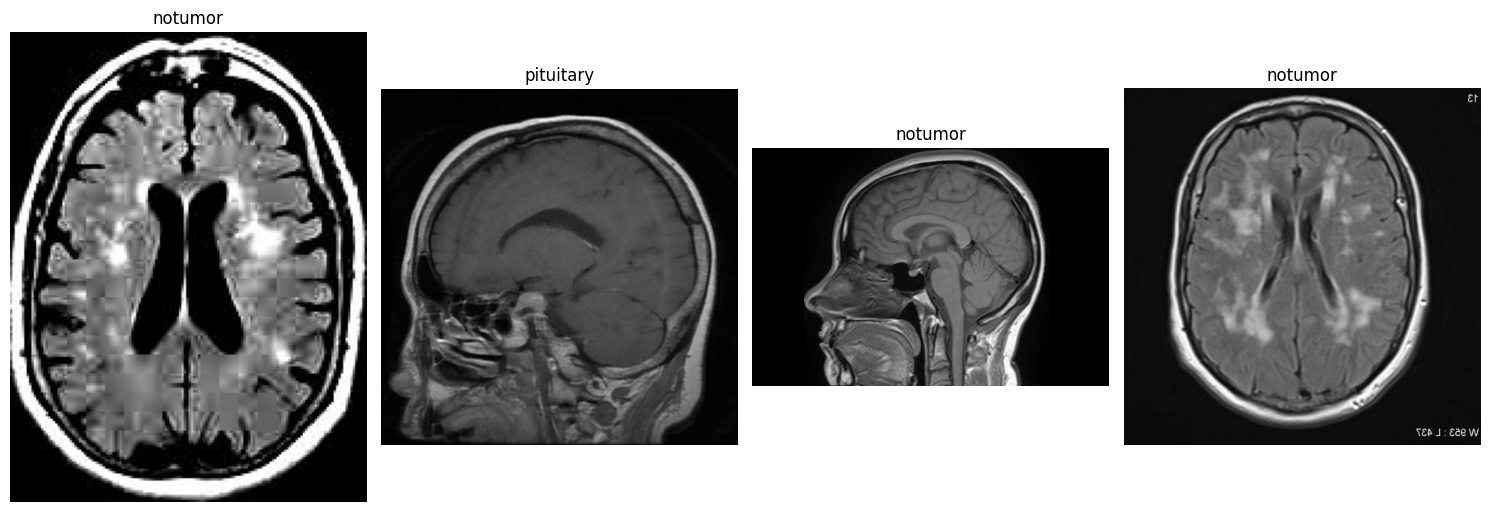

In [3]:
# Display some of the images
image_files_with_labels = [(str(image_path), image_path.parent.name) for image_path in train_path.glob("**/*.jpg")]
num_images_to_display = 4
selected_images = random.sample(image_files_with_labels, num_images_to_display)
plt.figure(figsize=(15, 15))
for i, (image_path, label) in enumerate(selected_images):
    plt.subplot(3, num_images_to_display, i + 1)
    plt.imshow(plt.imread(image_path))
    plt.title(label)
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
#Divide data in two parts 1 data directory 2 label (parent.name)
train_set = [(str(image_path), image_path.parent.name) for image_path in train_path.glob("**/*.jpg")]
test_set = [(str(image_path), image_path.parent.name) for image_path in test_path.glob("**/*.jpg")]

train, label_train = zip(*train_set)
test, label_test = zip(*test_set)

# Function that format and convert img
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))  # Load and resize image
    img_array = img_to_array(img)  # Convert image to array
    img_array /= 255.0  # Normalize pixel values to [0, 1]
    return img_array

x_train_samp = np.array([preprocess_image(x) for x in train])
x_test_samp = np.array([preprocess_image(x) for x in test])

x_train_samp.shape, x_test_samp.shape # check shapes

((5712, 224, 224, 3), (1311, 224, 224, 3))

In [5]:
# Encode and prepare data
#train set
encoder = OrdinalEncoder() # Use ordinal encoder since we have binary classification
label_train = np.array(label_train).reshape(-1, 1) # label_train is tuple make it numpy for training
y_train_samp = encoder.fit_transform(label_train)
y_train_samp.shape

#test set
label_test = np.array(label_test).reshape(-1, 1)
y_test_samp = encoder.fit_transform(label_test)

print(y_train_samp.shape)
print(y_test_samp.shape)

(5712, 1)
(1311, 1)


In [6]:
# Set seeds for reproducibility
tf.random.set_seed(45)
np.random.seed(45)

# Define augmentation parameters
datagen = ImageDataGenerator(
    zoom_range=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)



In [7]:
# Define your model
model = Sequential([
    Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(224, 224, 3)),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    Conv2D(64, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), padding='same', activation='relu'),
    Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(512, (3, 3), padding='same', activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(10, activation='softmax')
])



/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:

#compile the model
loss_fn = keras.losses.SparseCategoricalCrossentropy()
model.compile(optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4), loss=loss_fn, metrics=['accuracy'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

# Configure the learning rate reduction callback
learning_rate_reduce = ReduceLROnPlateau(
    monitor='val_acc',   # Metric to monitor for changes (usually validation accuracy)
    patience=5,          # Number of epochs with no improvement after which learning rate will be reduced
    verbose=1,           # Verbosity mode (0: silent, 1: update messages)
    factor=0.5,          # Factor by which the learning rate will be reduced (e.g., 0.5 means halving)
    min_lr=0.00001       # Lower bound for the learning rate (it won't go below this value)
)

In [9]:
# Train the model
history = model.fit(
    datagen.flow(x_train_samp, y_train_samp, batch_size=32),
    steps_per_epoch=int(len(x_train_samp) / 32),
    epochs=5,
    validation_data=(x_test_samp, y_test_samp),
    callbacks=[early_stopping, learning_rate_reduce]

)


Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1719756858.286523      75 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719756858.312406      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


161/178 ━━━━━━━━━━━━━━━━━━━━ 8s 478ms/step - accuracy: 0.2872 - loss: 1.5026

W0000 00:00:1719756934.825245      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 0s 453ms/step - accuracy: 0.2923 - loss: 1.4892

W0000 00:00:1719756941.625837      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


178/178 ━━━━━━━━━━━━━━━━━━━━ 138s 540ms/step - accuracy: 0.2926 - loss: 1.4884 - val_accuracy: 0.4554 - val_loss: 1.2929 - learning_rate: 1.0000e-04
Epoch 2/5


W0000 00:00:1719756954.030356      75 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/callback_list.py:96: UserWarning: Learning rate reduction is conditioned on metric `val_acc` which is not available. Available metrics are: accuracy,loss,val_accuracy,val_loss,learning_rate.
  callback.on_epoch_end(epoch, logs)


  1/178 ━━━━━━━━━━━━━━━━━━━━ 21s 124ms/step - accuracy: 0.5312 - loss: 0.9383

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5312 - loss: 0.9383 - val_accuracy: 0.4661 - val_loss: 1.2701 - learning_rate: 1.0000e-04
Epoch 3/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 68s 367ms/step - accuracy: 0.5501 - loss: 1.0239 - val_accuracy: 0.5606 - val_loss: 1.0431 - learning_rate: 1.0000e-04
Epoch 4/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5625 - loss: 0.9838 - val_accuracy: 0.5919 - val_loss: 1.0110 - learning_rate: 1.0000e-04
Epoch 5/5
178/178 ━━━━━━━━━━━━━━━━━━━━ 59s 319ms/step - accuracy: 0.6287 - loss: 0.8842 - val_accuracy: 0.6064 - val_loss: 0.9498 - learning_rate: 1.0000e-04


In [10]:
# Collect all TL models
resnet = ResNet50V2(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

for layer in resnet.layers:
    layer.trainable = False

94668760/94668760 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
    # Create the simplest model architecture using the current backbone.
model = keras.Sequential([
        resnet,
        layers.GlobalAveragePooling2D(),
        layers.Dropout(0.5),
        layers.Dense(10, activation='softmax')
    ])

    # Compile the model with the specified loss function, optimizer, and metrics.
model.compile(
        loss='categorical_crossentropy',
        optimizer= "adam",
        metrics=['accuracy']
    )

batch_size=64
y_train_samp_onehot = tf.keras.utils.to_categorical(y_train_samp, num_classes=10)
y_test_samp_onehot = tf.keras.utils.to_categorical(y_test_samp, num_classes=10)
history = model.fit(
        x_train_samp, y_train_samp_onehot,
        epochs=10,
        validation_data=(x_test_samp, y_test_samp_onehot),
        batch_size=batch_size
    )

Epoch 1/10
 1/90 ━━━━━━━━━━━━━━━━━━━━ 38:42 26s/step - accuracy: 0.2188 - loss: 2.8337

W0000 00:00:1719757121.059196      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 240ms/step - accuracy: 0.5245 - loss: 1.3150

W0000 00:00:1719757142.473316      73 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1719757148.238093      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 66s 453ms/step - accuracy: 0.5260 - loss: 1.3105 - val_accuracy: 0.8101 - val_loss: 0.4811
Epoch 2/10
 1/90 ━━━━━━━━━━━━━━━━━━━━ 14s 159ms/step - accuracy: 0.7344 - loss: 0.5882

W0000 00:00:1719757161.492907      76 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8097 - loss: 0.5064 - val_accuracy: 0.8650 - val_loss: 0.4036
Epoch 3/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8479 - loss: 0.4092 - val_accuracy: 0.8802 - val_loss: 0.3606
Epoch 4/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.8738 - loss: 0.3462 - val_accuracy: 0.8848 - val_loss: 0.3337
Epoch 5/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 156ms/step - accuracy: 0.8805 - loss: 0.3177 - val_accuracy: 0.8909 - val_loss: 0.3182
Epoch 6/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8874 - loss: 0.3115 - val_accuracy: 0.8917 - val_loss: 0.3221
Epoch 7/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8914 - loss: 0.3000 - val_accuracy: 0.8917 - val_loss: 0.2957
Epoch 8/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8893 - loss: 0.2907 - val_accuracy: 0.9008 - val_loss: 0.2882
Epoch 9/10
90/90 ━━━━━━━━━━━━━━━━━━━━ 14s 157ms/step - accuracy: 0.8950 - loss: 0.2623 - val_accuracy: 0.903

In [12]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50v2 (Functional)         │ (None, 7, 7, 2048)     │    23,564,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        20,490 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,626,272 (90.13 MB)

 Trainable params: 20,490 (80.04 KB)

 Non-trainable params: 23,564,800 (89.89 MB)

 Optimizer params: 40,982 (160.09 KB)

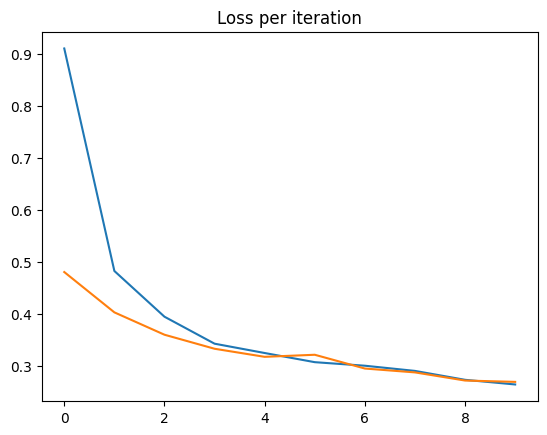

In [13]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.title('Loss per iteration')
plt.show()

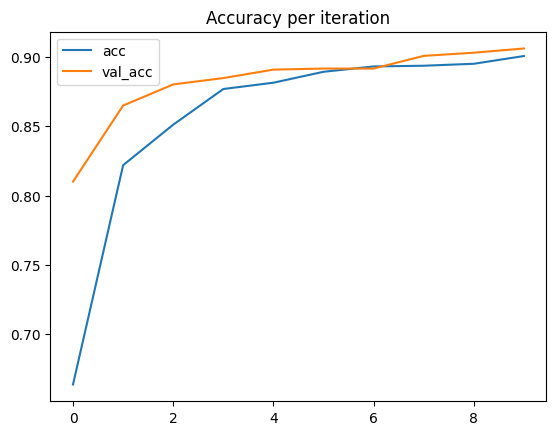

In [14]:
# Accuracy per iteration
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.title('Accuracy per iteration')
plt.legend()
plt.show()

In [15]:
yhat = model.predict(x_test_samp) # Predict
y_pred = (yhat > 0.5).astype(int) # threhold

 4/41 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step

W0000 00:00:1719757304.883413      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


41/41 ━━━━━━━━━━━━━━━━━━━━ 18s 146ms/step


W0000 00:00:1719757310.739071      74 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


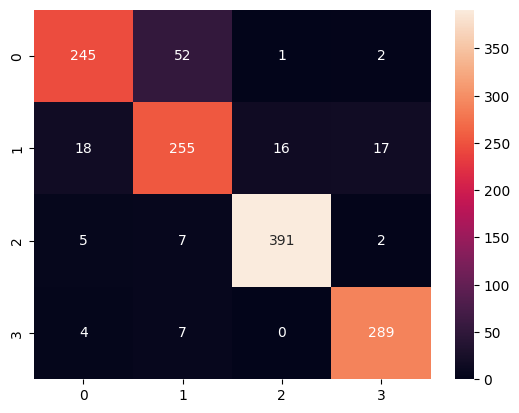

In [16]:
# Convert one-hot encoded labels back to original labels
y_test_samp_labels = np.argmax(y_test_samp_onehot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Draw Confusion Matrix
sns.heatmap(confusion_matrix(y_test_samp_labels, y_pred_labels), annot=True, fmt='g')
plt.show()

In [17]:
# Convert one-hot encoded labels back to original labels
y_test_samp_labels = np.argmax(y_test_samp_onehot, axis=1)
y_pred_labels = np.argmax(y_pred, axis=1)

# Print classification report
print(classification_report(y_test_samp_labels, y_pred_labels))

# Compute and print accuracy score
accuracy = accuracy_score(y_test_samp_labels, y_pred_labels)
print("Model accuracy: ", accuracy)

              precision    recall  f1-score   support

           0       0.90      0.82      0.86       300
           1       0.79      0.83      0.81       306
           2       0.96      0.97      0.96       405
           3       0.93      0.96      0.95       300

    accuracy                           0.90      1311
   macro avg       0.90      0.89      0.89      1311
weighted avg       0.90      0.90      0.90      1311

Model accuracy:  0.9000762776506483


In [18]:
tf.keras.models.save_model(model, 'model_yh.keras')

In [19]:
load = tf.keras.models.load_model('model_yh.keras')

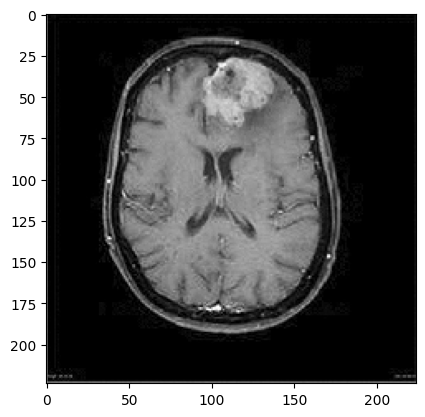

In [20]:
img_path = '/kaggle/input/oihgpbyvup/menin.jpg'
img = preprocess_image(img_path)
plt.imshow(img)

In [21]:
 # Make predictions using the model
img_array = np.expand_dims(img, axis=0)
pred_probs = load.predict(img_array)[0]

# Get the predicted class and its probability
pred_id = np.argmax(pred_probs)
prob = pred_probs[pred_id]


print(f"Probability: {prob * 100:.1f}%")
print(pred_id)

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Probability: 65.2%
2
